In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# define the helper function
def approximate_softmax(x, N):
    return torch.exp(x) / (torch.exp(x) + N)

In [3]:
class FiveParamModel(nn.Module):
    """
    Model with five learnable parameters:
      beta1, alpha2, alpha3, gamma, zeta
    It computes:
      y = alpha2 * approximate_softmax(beta1, N)
      z = alpha3 * approximate_softmax(y, 2N)
      w = gamma  * approximate_softmax(y, N)

      pi_l = (approximate_softmax(z, 2N)*approximate_softmax(beta1, N)
              + approximate_softmax(w, 2N)*approximate_softmax(y, N)) * zeta

      L = -log(pi_l)
    """
    def __init__(self, N=10):
        super(FiveParamModel, self).__init__()
        self.N_value = N 
        self.beta1  = nn.Parameter(torch.randn(1, dtype=torch.float32))
        self.alpha2 = nn.Parameter(torch.randn(1, dtype=torch.float32))
        self.alpha3 = nn.Parameter(torch.randn(1, dtype=torch.float32))
        self.gamma  = nn.Parameter(torch.randn(1, dtype=torch.float32))
        self.zeta   = nn.Parameter(torch.randn(1, dtype=torch.float32))

        # Internal flags to fix any subset of parameters
        # If a parameter is in self.fixed_params dictionary, it will be forced
        # to that fixed value during the forward pass (and will not update).
        self.fixed_params = {}  # e.g. {'gamma': 0.0, 'zeta': 1.0}

    def set_fixed_params(self, fixed_dict):
        """
        Provide a dictionary of parameter_name -> fixed_value
        to fix any subset of parameters to a chosen constant.
        Example: {'gamma': 0.0, 'zeta': 1.0, 'alpha3': 0.0}
        """
        self.fixed_params = fixed_dict

    def set_parameter_values(self, beta1_val=None, alpha2_val=None,
                             alpha3_val=None, gamma_val=None, zeta_val=None):
        """
        Manually set initial values for the five parameters.
        Any parameter that is not None here will be overridden.
        """
        if beta1_val is not None:
            with torch.no_grad():
                self.beta1.fill_(beta1_val)
        if alpha2_val is not None:
            with torch.no_grad():
                self.alpha2.fill_(alpha2_val)
        if alpha3_val is not None:
            with torch.no_grad():
                self.alpha3.fill_(alpha3_val)
        if gamma_val is not None:
            with torch.no_grad():
                self.gamma.fill_(gamma_val)
        if zeta_val is not None:
            with torch.no_grad():
                self.zeta.fill_(zeta_val)

    def forward(self):
        """
        Returns the loss = -log(pi_l)
        """
        # If any params are fixed, override them
        # (so that in forward pass they remain at the fixed value).
        with torch.no_grad():
            for pname, val in self.fixed_params.items():
                getattr(self, pname).fill_(val)

        # Extract parameters
        beta1  = self.beta1
        alpha2 = self.alpha2
        alpha3 = self.alpha3
        gamma  = self.gamma
        zeta   = self.zeta

        # The fixed integer N
        N = self.N_value
        
        # y, z, w computations
        y = alpha2 * approximate_softmax(beta1, N)
        w = gamma  * approximate_softmax(beta1, N)
        z = alpha3 * (approximate_softmax(y, N) + approximate_softmax(w, N)) * approximate_softmax(beta1, N) * zeta

        # pi_l
        pi_l  = approximate_softmax(z, 30) 

        # Loss
        loss = -torch.log(pi_l + 1e-15)  # add small eps to avoid log(0)
        return loss


In [4]:
# Training function.
def train_model(model,
                num_iterations=2000,
                lr=1e-2,
                optimizer_name='Adam',
                verbose=True):
    """
    Train the model for num_iterations using chosen optimizer and lr.
    Options for optimizer_name: 'Adam', 'AdamW', 'SGD'.
    During training, we record the parameters and the loss.
    """
    # Select the optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError("Unknown optimizer_name. Use 'Adam', 'AdamW', or 'SGD'.")

    # Tracking
    loss_list = []
    beta1_list = []
    alpha2_list = []
    alpha3_list = []
    gamma_list = []
    zeta_list = []

    for step in range(num_iterations):
        optimizer.zero_grad()
        loss = model()
        loss.backward()

        # If any parameter is fixed, we want to zero out its gradient so it doesn't update
        # (Alternatively, we could remove it from the optimizer's parameter list,
        # or forcibly fill it in the forward pass.)
        for pname in model.fixed_params:
            getattr(model, pname).grad = torch.zeros_like(getattr(model, pname).grad)

        optimizer.step()

        # Record the values
        loss_list.append(loss.item())
        beta1_list.append(model.beta1.item())
        alpha2_list.append(model.alpha2.item())
        alpha3_list.append(model.alpha3.item())
        gamma_list.append(model.gamma.item())
        zeta_list.append(model.zeta.item())

        if verbose and step % max(num_iterations//10,1) == 0:
            print(f"Iter {step}, Loss = {loss.item():.6f}, ",
                  f"beta1={model.beta1.item():.4f}, alpha2={model.alpha2.item():.4f},",
                  f"alpha3={model.alpha3.item():.4f}, gamma={model.gamma.item():.4f}, zeta={model.zeta.item():.4f}")

    # Return records for plotting
    return {
      'loss': loss_list,
      'beta1': beta1_list,
      'alpha2': alpha2_list,
      'alpha3': alpha3_list,
      'gamma': gamma_list,
      'zeta': zeta_list
    }



In [16]:
def plot_trajectories(logs, max_range=None, plot_params=True):
    """
    Plots the loss trajectory and optionally the three parameters.
    
    Args:
        logs: Dictionary containing loss and parameter values
        max_range: Maximum number of steps to plot
        plot_params: If True, plot parameters. If False, only plot loss
    """
    steps = range(len(logs['loss']))
    max_range = len(steps) if not max_range else max_range
    
    # Set up colors
    cols = ["#7aa0c4", "#ca82e1", "#8bcd50", "#df9f53", "#64b9a1",
            "#745ea6", "#db7e76"]
    linesize = 3
    fontsize = 22

    # Create figure 1 for loss
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    
    # Plot loss
    ax1.plot(steps[:max_range], logs['loss'][:max_range],
            color=cols[0], label='Loss', linewidth=linesize)
    ax1.set_ylabel("Loss", fontsize=fontsize, )
    ax1.tick_params(axis='y',)
    
    # Customize spines for ax1
    for spine in ax1.spines.values():
        spine.set_linewidth(linesize)
        
    # Labels and ticks for ax1
    ax1.set_xlabel("Training Steps", fontsize=fontsize)
    ax1.set_xticks([0, 500, 1000, 1500, 2000])
    ax1.tick_params(axis='both', which='major', labelsize=fontsize)
    ax1.legend(fontsize=fontsize, frameon=True)

    if plot_params:
        # Create figure 2 for parameters
        fig2, ax2 = plt.subplots(figsize=(6, 6))
        
        # Plot parameters
        ax2.plot(steps[:max_range], logs['beta1'][:max_range], 
                color=cols[0], label=r'$\alpha$', linestyle='-', linewidth=linesize)
        ax2.plot(steps[:max_range], logs['alpha2'][:max_range], 
                color=cols[1], label=r'$\beta$', linestyle='--', linewidth=linesize)
        ax2.plot(steps[:max_range], logs['alpha3'][:max_range], 
                color=cols[2], label=r'$\gamma$', linestyle='-.', linewidth=linesize)
        ax2.set_ylabel("Parameters", fontsize=fontsize)
        
        # Customize spines for ax2
        for spine in ax2.spines.values():
            spine.set_linewidth(linesize)
            
        # Labels and ticks for ax2
        ax2.set_xlabel("Training Steps", fontsize=fontsize)
        ax2.set_xticks([0, 500, 1000, 1500, 2000])
        ax2.tick_params(axis='both', which='major', labelsize=fontsize)
        ax2.legend(fontsize=fontsize, frameon=True)
        
        plt.figure(fig2.number)
        plt.tight_layout()
        plt.savefig("extra_figures/param_dynamics_params.pdf", bbox_inches='tight')
    
    plt.figure(fig1.number)
    plt.tight_layout()
    plt.savefig("extra_figures/param_dynamics_loss.pdf", bbox_inches='tight')
    
    plt.show()


Iter 0, Loss = 3.418776,  beta1=-0.4040, alpha2=-0.6635, alpha3=1.4107, gamma=0.0000, zeta=1.0000
Iter 400, Loss = 3.383551,  beta1=0.5451, alpha2=-0.6153, alpha3=2.0401, gamma=0.0000, zeta=1.0000
Iter 800, Loss = 0.153631,  beta1=5.2706, alpha2=4.0256, alpha3=6.0142, gamma=0.0000, zeta=1.0000
Iter 1200, Loss = 0.017159,  beta1=5.8194, alpha2=5.0153, alpha3=7.5332, gamma=0.0000, zeta=1.0000
Iter 1600, Loss = 0.009235,  beta1=5.9526, alpha2=5.2318, alpha3=8.0245, gamma=0.0000, zeta=1.0000
Iter 2000, Loss = 0.006339,  beta1=6.0293, alpha2=5.3525, alpha3=8.3308, gamma=0.0000, zeta=1.0000
Iter 2400, Loss = 0.004832,  beta1=6.0828, alpha2=5.4350, alpha3=8.5548, gamma=0.0000, zeta=1.0000
Iter 2800, Loss = 0.003907,  beta1=6.1236, alpha2=5.4971, alpha3=8.7317, gamma=0.0000, zeta=1.0000
Iter 3200, Loss = 0.003281,  beta1=6.1566, alpha2=5.5466, alpha3=8.8781, gamma=0.0000, zeta=1.0000
Iter 3600, Loss = 0.002828,  beta1=6.1841, alpha2=5.5877, alpha3=9.0031, gamma=0.0000, zeta=1.0000


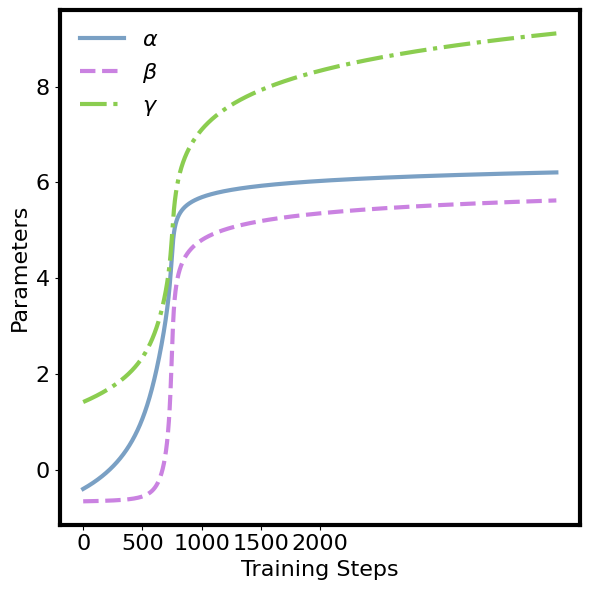

In [6]:
### A 4-paramter model.

# Create a model
model = FiveParamModel(N=10)

# Optionally set fixed parameters
# e.g. fix gamma=0 and zeta=1
model.set_fixed_params({'zeta': 1.0, 'gamma': 0})

# Optionally set custom initial values
# model.set_parameter_values(gamma_val=3.0)

# Train
logs = train_model(model,
                num_iterations=4000, 
                lr=0.1, 
                optimizer_name='SGD', 
                verbose=True)

# Plot the trajectories
plot_trajectories(logs)


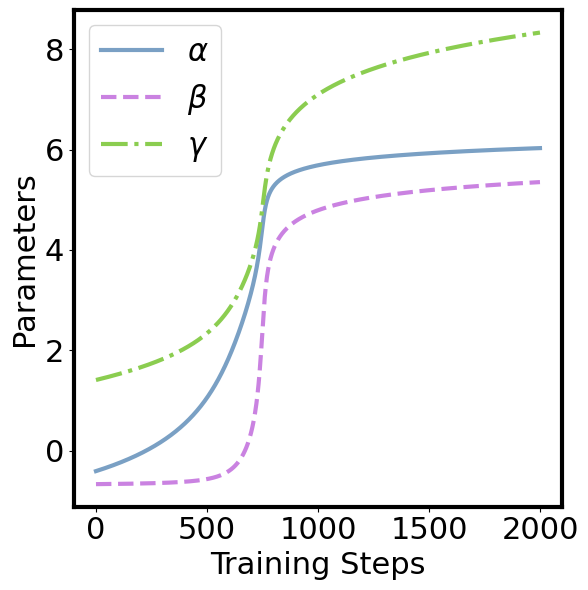

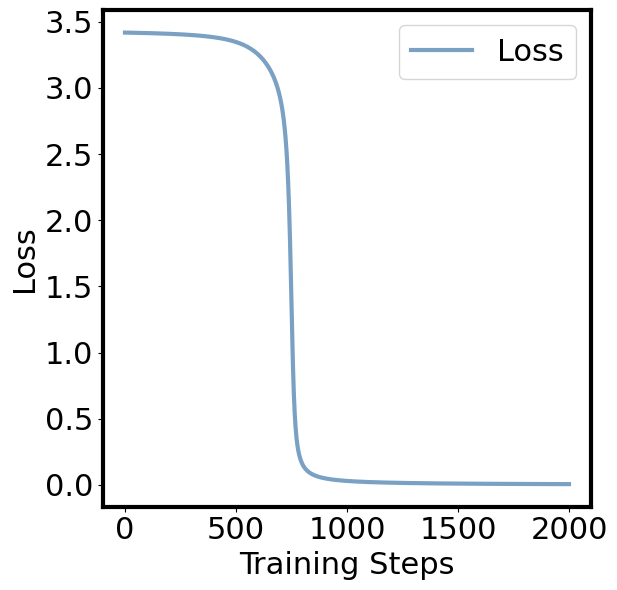

In [17]:
plot_trajectories(logs, 2000, plot_params=True)

Iter 0, Loss = 3.037728,  beta1=0.1998, alpha2=-1.0660, alpha3=0.3799, gamma=0.0000, zeta=1.0000
Iter 5000, Loss = 2.988817,  beta1=1.0846, alpha2=-0.9864, alpha3=1.5573, gamma=0.0000, zeta=1.0000
Iter 10000, Loss = 0.053488,  beta1=5.4893, alpha2=4.3562, alpha3=6.4067, gamma=0.0000, zeta=1.0000
Iter 15000, Loss = 0.011977,  beta1=5.8401, alpha2=4.9958, alpha3=7.4908, gamma=0.0000, zeta=1.0000
Iter 20000, Loss = 0.006839,  beta1=5.9583, alpha2=5.1945, alpha3=7.9342, gamma=0.0000, zeta=1.0000
Iter 25000, Loss = 0.004802,  beta1=6.0295, alpha2=5.3102, alpha3=8.2210, gamma=0.0000, zeta=1.0000
Iter 30000, Loss = 0.003705,  beta1=6.0801, alpha2=5.3908, alpha3=8.4343, gamma=0.0000, zeta=1.0000
Iter 35000, Loss = 0.003019,  beta1=6.1192, alpha2=5.4521, alpha3=8.6043, gamma=0.0000, zeta=1.0000
Iter 40000, Loss = 0.002548,  beta1=6.1509, alpha2=5.5014, alpha3=8.7459, gamma=0.0000, zeta=1.0000
Iter 45000, Loss = 0.002205,  beta1=6.1776, alpha2=5.5424, alpha3=8.8673, gamma=0.0000, zeta=1.0000


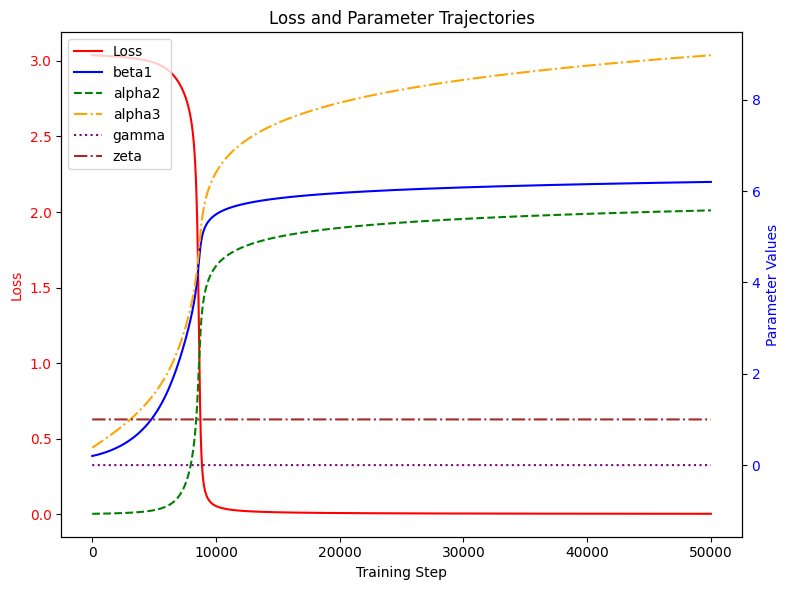

In [44]:
### A 4-paramter model, with gamma fixed 

# Create a model
model = FiveParamModel(N=10)

# Optionally set fixed parameters
# e.g. fix gamma=0 and zeta=1
model.set_fixed_params({'gamma': 0.0,'zeta': 1.0})

# Optionally set custom initial values
# model.set_parameter_values(gamma_val=3.0)

# Train
logs = train_model(model,
                num_iterations=50000, 
                lr=0.01, 
                optimizer_name='SGD', 
                verbose=True)

# Plot the trajectories
plot_trajectories(logs)


Iter 0, Loss = 3.069706,  beta1=0.5661, alpha2=0.0000, alpha3=-0.9495, gamma=0.3115, zeta=1.0000
Iter 5000, Loss = 3.043021,  beta1=0.1684, alpha2=0.0000, alpha3=0.0810, gamma=0.2853, zeta=1.0000
Iter 10000, Loss = 3.005672,  beta1=0.7983, alpha2=0.0000, alpha3=1.2022, gamma=0.3323, zeta=1.0000
Iter 15000, Loss = 0.043569,  beta1=5.5676, alpha2=0.0000, alpha3=6.3547, gamma=4.7544, zeta=1.0000
Iter 20000, Loss = 0.011958,  beta1=5.8664, alpha2=0.0000, alpha3=7.3904, gamma=5.2160, zeta=1.0000
Iter 25000, Loss = 0.006942,  beta1=5.9791, alpha2=0.0000, alpha3=7.8425, gamma=5.3818, zeta=1.0000
Iter 30000, Loss = 0.004894,  beta1=6.0481, alpha2=0.0000, alpha3=8.1369, gamma=5.4813, zeta=1.0000
Iter 35000, Loss = 0.003780,  beta1=6.0975, alpha2=0.0000, alpha3=8.3560, gamma=5.5515, zeta=1.0000
Iter 40000, Loss = 0.003080,  beta1=6.1359, alpha2=0.0000, alpha3=8.5307, gamma=5.6053, zeta=1.0000
Iter 45000, Loss = 0.002599,  beta1=6.1670, alpha2=0.0000, alpha3=8.6760, gamma=5.6489, zeta=1.0000


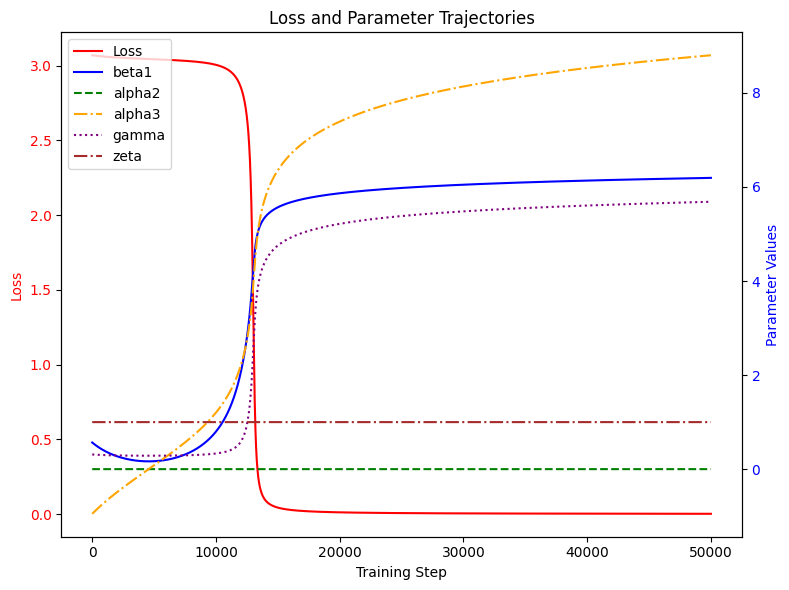

In [45]:
### A 4-paramter model, with alpha2 fixed 

# Create a model
model = FiveParamModel(N=10)

# Optionally set fixed parameters
# e.g. fix gamma=0 and zeta=1
model.set_fixed_params({'alpha2': 0.0,'zeta': 1.0})

# Optionally set custom initial values
# model.set_parameter_values(gamma_val=3.0)

# Train
logs = train_model(model,
                num_iterations=50000, 
                lr=0.01, 
                optimizer_name='SGD', 
                verbose=True)

# Plot the trajectories
plot_trajectories(logs)


Iter 0, Loss = 3.042405,  beta1=-0.8078, alpha2=0.6388, alpha3=0.5549, gamma=1.1367, zeta=1.0000
Iter 5000, Loss = 3.041237,  beta1=-0.6775, alpha2=0.6443, alpha3=0.7575, gamma=1.1367, zeta=1.0000
Iter 10000, Loss = 3.039251,  beta1=-0.4736, alpha2=0.6543, alpha3=0.9956, gamma=1.1367, zeta=1.0000
Iter 15000, Loss = 3.034853,  beta1=-0.1284, alpha2=0.6764, alpha3=1.3051, gamma=1.1367, zeta=1.0000
Iter 20000, Loss = 3.016473,  beta1=0.6342, alpha2=0.7598, alpha3=1.8189, gamma=1.1375, zeta=1.0000
Iter 25000, Loss = 0.074298,  beta1=5.5322, alpha2=4.9591, alpha3=6.2544, gamma=1.1832, zeta=1.0000
Iter 30000, Loss = 0.015804,  beta1=5.9265, alpha2=5.5075, alpha3=7.6513, gamma=1.2045, zeta=1.0000
Iter 35000, Loss = 0.008810,  beta1=6.0549, alpha2=5.6785, alpha3=8.1936, gamma=1.2140, zeta=1.0000
Iter 40000, Loss = 0.006105,  beta1=6.1311, alpha2=5.7782, alpha3=8.5370, gamma=1.2204, zeta=1.0000
Iter 45000, Loss = 0.004670,  beta1=6.1849, alpha2=5.8478, alpha3=8.7891, gamma=1.2253, zeta=1.0000


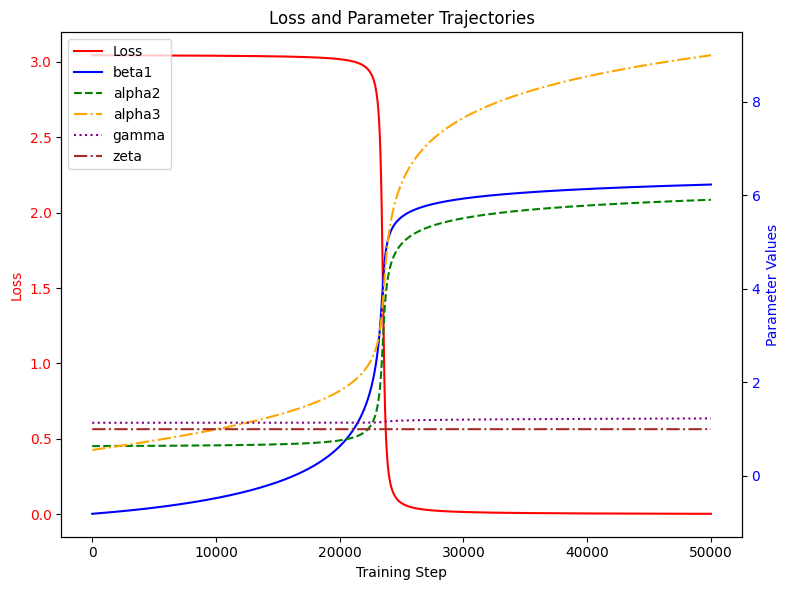

In [50]:
### A 4-paramter model, with a bias in gamma = -5.0

# Create a model
model = FiveParamModel(N=10)

# Optionally set fixed parameters
# e.g. fix gamma=0 and zeta=1
model.set_fixed_params({'zeta': 1.0})

# Optionally set custom initial values
# model.set_parameter_values(gamma_val=3.0)

# Train
logs = train_model(model,
                num_iterations=50000, 
                lr=0.01, 
                optimizer_name='SGD', 
                verbose=True)

# Plot the trajectories
plot_trajectories(logs)


Iter 0, Loss = 2.892909,  beta1=0.9527, alpha2=-2.6703, alpha3=0.7393, gamma=-1.2112, zeta=1.0000
Iter 5000, Loss = 0.024546,  beta1=5.2678, alpha2=-2.4393, alpha3=6.9777, gamma=-1.1864, zeta=1.0000
Iter 10000, Loss = 0.010962,  beta1=5.5073, alpha2=-2.3873, alpha3=7.7417, gamma=-1.1790, zeta=1.0000
Iter 15000, Loss = 0.007037,  beta1=5.6276, alpha2=-2.3553, alpha3=8.1631, gamma=-1.1745, zeta=1.0000
Iter 20000, Loss = 0.005177,  beta1=5.7067, alpha2=-2.3316, alpha3=8.4553, gamma=-1.1712, zeta=1.0000
Iter 25000, Loss = 0.004093,  beta1=5.7653, alpha2=-2.3126, alpha3=8.6793, gamma=-1.1686, zeta=1.0000
Iter 30000, Loss = 0.003384,  beta1=5.8114, alpha2=-2.2966, alpha3=8.8609, gamma=-1.1664, zeta=1.0000
Iter 35000, Loss = 0.002883,  beta1=5.8494, alpha2=-2.2827, alpha3=9.0137, gamma=-1.1646, zeta=1.0000
Iter 40000, Loss = 0.002512,  beta1=5.8816, alpha2=-2.2704, alpha3=9.1454, gamma=-1.1629, zeta=1.0000
Iter 45000, Loss = 0.002225,  beta1=5.9093, alpha2=-2.2593, alpha3=9.2612, gamma=-1.161

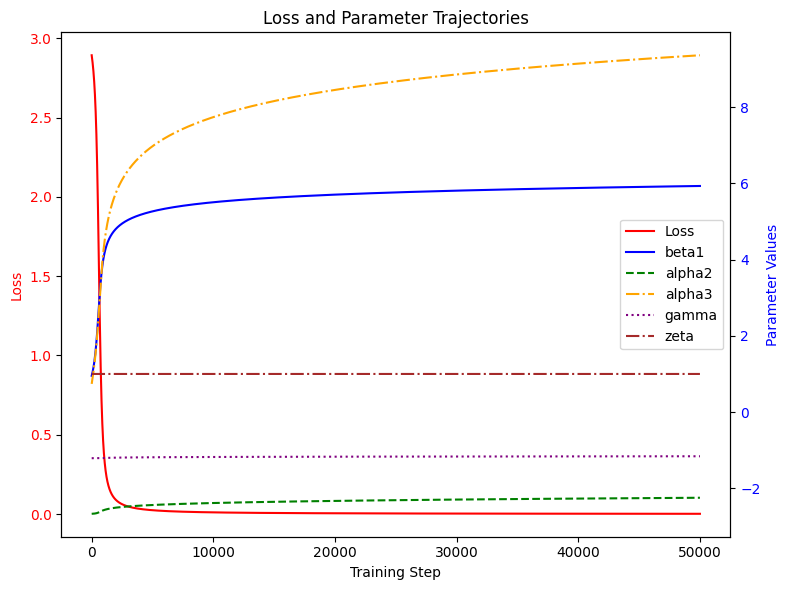

In [53]:
### A 4-paramter model, with a bias in gamma = 10.0

# Create a model
model = FiveParamModel(N=10)

# Optionally set fixed parameters
# e.g. fix gamma=0 and zeta=1
model.set_fixed_params({'zeta': 1.0})

# Optionally set custom initial values
# model.set_parameter_values(gamma_val=3.0)

# Train
logs = train_model(model,
                num_iterations=50000, 
                lr=0.01, 
                optimizer_name='SGD', 
                verbose=True)

# Plot the trajectories
plot_trajectories(logs)
